In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
# reading and merging 

df = pd.read_csv("train.csv", low_memory= False)
store = pd.read_csv("store.csv")

df = df.merge(store, on="Store", how="left")

In [24]:
# -------------------
# Basic Cleanup
# -------------------

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Drop closed days (sales = 0)
df = df[df["Open"] == 1]

# Convert StateHoliday
df['StateHoliday'] = df['StateHoliday'].replace({'0': 0, 'a': 1, 'b': 2, 'c': 3}).astype(int)

# -------------------
# Feature Engineering
# -------------------
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsWeekend'] = df['DayOfWeek'].isin([6,7]).astype(int)

# -------------------
# Handle Missing Store Data
# -------------------

# CompetitionDistance NaN → very large distance
df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].median())

# Promo2 and related columns
df['Promo2'] = df['Promo2'].fillna(0).astype(int)

df['Promo2SinceWeek'] = df['Promo2SinceWeek'].fillna(0).astype(int)
df['Promo2SinceYear'] = df['Promo2SinceYear'].fillna(0).astype(int)

# Competition open dates
df['CompetitionOpenSinceMonth'] = df['CompetitionOpenSinceMonth'].fillna(0).astype(int)
df['CompetitionOpenSinceYear'] = df['CompetitionOpenSinceYear'].fillna(0).astype(int)

# -------------------
# Time-based Lag Features (store-wise)
# -------------------
df = df.sort_values(['Store', 'Date'])

df['Sales_lag1'] = df.groupby('Store')['Sales'].shift(1)
df['Sales_lag7'] = df.groupby('Store')['Sales'].shift(7)
df['Sales_lag14'] = df.groupby('Store')['Sales'].shift(14)

df['Sales_roll7'] = df.groupby('Store')['Sales'].shift(1).rolling(7).mean()
df['Sales_roll30'] = df.groupby('Store')['Sales'].shift(1).rolling(30).mean()

# Remove rows that became NaN due to lag features
df = df.dropna()

# -------------------
# Target Transformation
# -------------------
df['Sales'] = np.log1p(df['Sales'])

# -------------------
# Final Train Data
# -------------------
X = df.drop(['Sales', 'Date'], axis=1)
y = df['Sales']

print("Preprocessing complete. Shape:", X.shape)

Preprocessing complete. Shape: (403955, 26)


In [ ]:
# dropping the object type data irrelevant to the model training 

cols_to_drop = ['Date', 'StoreType', 'Assortment', 'PromoInterval']

df = df.drop(columns=cols_to_drop, errors='ignore')
print ("dropped")

dropped


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 403955 entries, 975956 to 1114
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      403955 non-null  int64  
 1   DayOfWeek                  403955 non-null  int64  
 2   Sales                      403955 non-null  float64
 3   Customers                  403955 non-null  int64  
 4   Open                       403955 non-null  int64  
 5   Promo                      403955 non-null  int64  
 6   StateHoliday               403955 non-null  int64  
 7   SchoolHoliday              403955 non-null  int64  
 8   CompetitionDistance        403955 non-null  float64
 9   CompetitionOpenSinceMonth  403955 non-null  int64  
 10  CompetitionOpenSinceYear   403955 non-null  int64  
 11  Promo2                     403955 non-null  int64  
 12  Promo2SinceWeek            403955 non-null  int64  
 13  Promo2SinceYear            4039

In [30]:
# Ensure data is sorted by date (VERY important)
df = df.sort_values("Year")  # or "Date" if Date exists before dropping

# Define test size (example: last 6 weeks = ~42 days)
test_size = int(0.10 * len(df))   # last 10% of data as test

# Create train & test sets
train_df = df.iloc[:-test_size]
test_df = df.iloc[-test_size:]

# Split X and y
X_train = train_df.drop("Sales", axis=1)
y_train = train_df["Sales"]

X_test = test_df.drop("Sales", axis=1)
y_test = test_df["Sales"]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (363560, 23) Test shape: (40395, 23)


In [37]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------
# Train the XGBoost model
# ------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist"   # fast training
)

model.fit(X_train, y_train)

print("Training completed!")


Training completed!


In [39]:
# predictions
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# errors
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))

train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)

train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("TRAIN RMSE:", train_rmse)
print("TEST RMSE:", test_rmse)
print("TRAIN MAE:", train_mae)
print("TEST MAE:", test_mae)
print("TRAIN R²:", train_r2)
print("TEST R²:", test_r2)


TRAIN RMSE: 0.05930822040610975
TEST RMSE: 0.06740539280378069
TRAIN MAE: 0.04495752532560781
TEST MAE: 0.051486729522561975
TRAIN R²: 0.9796133040520335
TEST R²: 0.9676198298047111


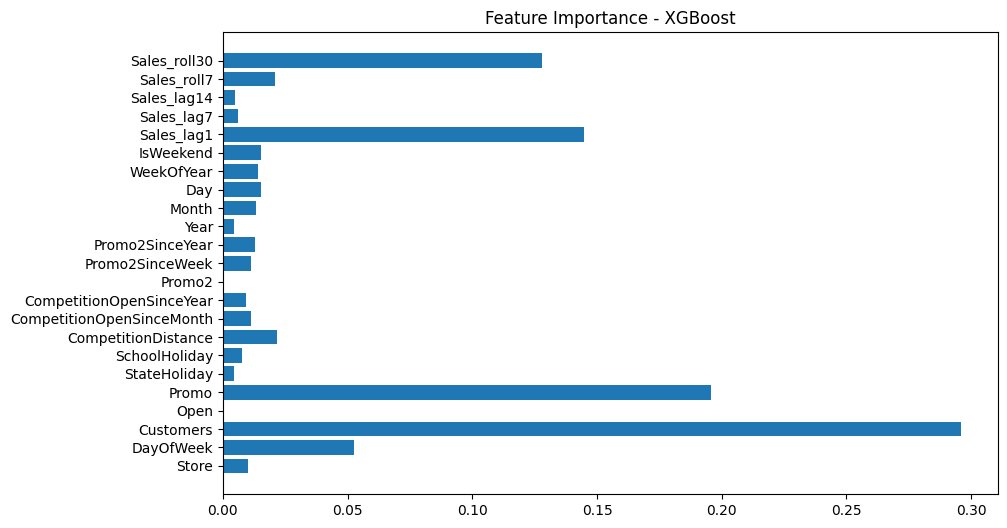

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, model.feature_importances_)
plt.title("Feature Importance - XGBoost")
plt.show()


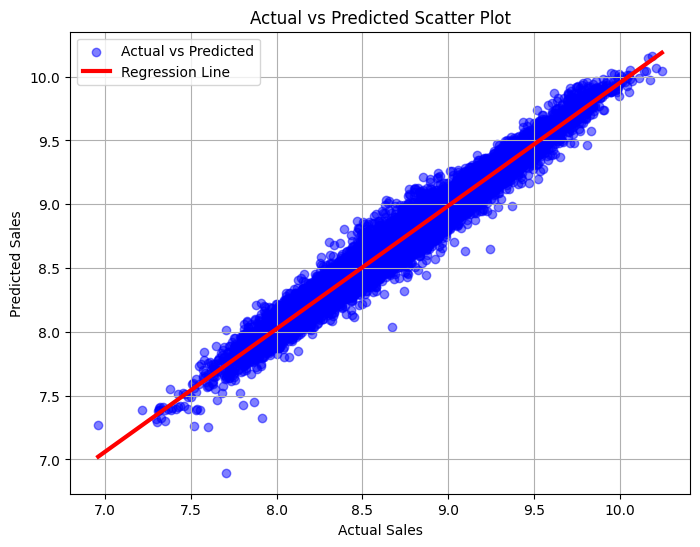

In [ ]:
import matplotlib.pyplot as plt

# Scatter plot: actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, test_pred, alpha=0.5, color="blue", label="Actual vs Predicted")

# Regression line (different color)
m, b = np.polyfit(y_test, test_pred, 1)
line_x = np.linspace(min(y_test), max(y_test), 100)
line_y = m * line_x + b

plt.plot(
    line_x, 
    line_y, 
    color="red",     
    linewidth=3, 
    label="Regression Line"
)

plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Scatter Plot")
plt.legend()
plt.grid(True)
plt.show()